# Assignment 2


You must submit your notebook by running `python3 -m autograder.run.submit Assignment2.ipynb` from your local repository.

To write legible answers you will need to be familiar with both [Markdown](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet) and [Latex](https://www.latex-tutorial.com/tutorials/amsmath/)

Before you turn this problem in, make sure everything runs as expected. To do so, restart the kernel and run all cells (in the menubar, select Runtime→→Restart and run all).

#### Show your work!
Whenever you are asked to find the solution to a problem, be sure to also **show how you arrived** at your answer.

Make sure you fill in any place that says "YOUR CODE HERE" or "YOUR ANSWERS HERE", as well as your name below:

## Some Helper Functions

Implement an evaluation function that takes in some board position and player colour and returns a score. 

In [1]:
import chess
import random
from math import inf
from IPython.display import display, clear_output

In [2]:
def evaluation(board: chess.Board, player: bool):
    """
    This function evaluates a board position and returns a score value.
    
    Parameters:
    - board: the chess board
    - player: the colour of the active player (True -> white, False -> black)
    
    Returns:
    - an integer score for a board state
    """
    # Central Control
    def center_control(board: chess.Board, player: bool):
        centeral = {chess.D5, chess.E5, chess.D4, chess.E4}
        i = 0
        for sq in centeral:
            if board.is_attacked_by(player, sq):
                i += 1
        return i

    # Pawn Structure
    black_pawns = board.pieces(chess.PAWN, chess.BLACK)
    white_pawns = board.pieces(chess.PAWN, chess.WHITE)

    blocked_pawns = {"white": 0, "black": 0}
    isolated_pawns = {"white": 0, "black": 0}
    doubled_pawns = {"white": 0, "black": 0}

    # Check for doubled and isolated pawns for both colors
    for color, pawns in [("white", white_pawns), ("black", black_pawns)]:
        lists = [chess.square_file(square) for square in pawns]  # File indices for pawns
        unique_f = set(lists)

        # Doubled pawns: More than one pawn on the same file
        for f in unique_f:
            count = lists.count(f)
            if count > 1:
                doubled_pawns[color] += count - 1  # Number of additional pawns on that file

        # Isolated pawns: No friendly pawns on adjacent lists
        for square in pawns:
            f = chess.square_file(square)
            if not any(chess.square_file(p) in {f - 1, f + 1} for p in pawns):
                isolated_pawns[color] += 1

    # Check for blocked pawns
    for color, pawns in [("white", white_pawns), ("black", black_pawns)]:
        if color == "black": # White pawns move +8, black pawns move -8
            move = -8 
        else:
            move = 8 
        for square in pawns:
            front_square = square + move
            if chess.SQUARES[0] <= front_square < 64:  # Ensure the front square is valid
                front_p = board.piece_at(front_square)
                # Check if the front piece is an opponent’s piece or any piece blocking the pawn
                if front_p is not None and front_p.color != color:
                    blocked_pawns[color] += 1
    
    # End of Pawn Structure

    # pawn - 10, knight - 30, bishop - 30, rook - 50, queen - 90, king - 900
    white_score = len(board.pieces(chess.PAWN, chess.WHITE)) * 10 + len(board.pieces(chess.KNIGHT, chess.WHITE)) * 30 + len(board.pieces(chess.BISHOP, chess.WHITE)) * 30 + len(board.pieces(chess.ROOK, chess.WHITE)) * 50 + len(board.pieces(chess.QUEEN, chess.WHITE)) * 90 + len(board.pieces(chess.KING, chess.WHITE)) * 900

    black_score = len(board.pieces(chess.PAWN, chess.BLACK)) * 10 + len(board.pieces(chess.KNIGHT, chess.BLACK)) * 30 + len(board.pieces(chess.BISHOP, chess.BLACK)) * 30 + len(board.pieces(chess.ROOK, chess.BLACK)) * 50 + len(board.pieces(chess.QUEEN, chess.BLACK)) * 90 + len(board.pieces(chess.KING, chess.BLACK)) * 900

    curr_turn = board.turn

    board.turn = chess.WHITE  
    white_legal_moves = list(board.legal_moves) 
    board.turn = chess.BLACK  
    black_legal_moves = list(board.legal_moves)  

    # set the turn back
    board.turn = curr_turn

    if player:  #white
        return white_score-black_score + (len(white_legal_moves)-len(black_legal_moves)) - 5 * (blocked_pawns["white"] - blocked_pawns["black"] + isolated_pawns["white"] - isolated_pawns["black"] + doubled_pawns["white"] - doubled_pawns["black"]) + 20 * (center_control(board, chess.WHITE) - center_control(board, chess.BLACK)) #+ 40 * (levy_development(board, chess.WHITE) - levy_development(board, chess.BLACK)) + 40 * (different_attacked_squares(board, chess.WHITE) - different_attacked_squares(board, chess.BLACK)) + 40 * (attacked_own_squares(board, chess.WHITE) - attacked_own_squares(board, chess.BLACK))
    
    return black_score-white_score + (len(black_legal_moves)-len(white_legal_moves)) - 5 * (blocked_pawns["black"] - blocked_pawns["white"] + isolated_pawns["black"] - isolated_pawns["white"] + doubled_pawns["black"] - doubled_pawns["white"]) + 20 * (center_control(board, chess.BLACK) - center_control(board, chess.WHITE)) #+ 40 * (levy_development(board, chess.BLACK) - levy_development(board, chess.WHITE)) + 40 * (different_attacked_squares(board, chess.BLACK) - different_attacked_squares(board, chess.WHITE)) + 40 * (attacked_own_squares(board, chess.BLACK) - attacked_own_squares(board, chess.WHITE))

def move_ordering(board):
    """Order moves based on captures and checks for better pruning."""
    def move_score(move):
        # Capture score: prioritize capturing higher-value pieces with lower-value ones
        if board.is_capture(move) and board.piece_at(move.from_square) and board.piece_at(move.to_square):
            captured_piece = board.piece_at(move.to_square)
            attacker_piece = board.piece_at(move.from_square)
            return (captured_piece.piece_type * 10) - attacker_piece.piece_type
        elif board.gives_check(move):
            return 5  # Prioritize moves that give check
        return 0  # Non-capturing, non-checking moves have lowest priority

    # Sort moves in descending order of their score
    return sorted(board.legal_moves, key=move_score, reverse=False)  


## Q1

Implement the minimax algorithm to choose the best chess move for a given board position, player colour, and look-ahead depth. Make use of your `evaluation()` function here to calculate the score of any individual board state.

In [3]:
def get_minimax_move(b: chess.Board, player: bool, depth: int):   
    """
    This function chooses the best move for the given board position, player, and depth.
    
    Parameters:
    - board: the chess board that the knight is moving upon
    - player: the colour of the active player (True -> white, False -> black)
    - depth: the number of moves that the algorithmn should look ahead.
    
    Returns:
    A single chess.Move type object.
    """
    def max_node(local_b, local_player, local_depth, a, b):
        if local_b.is_checkmate(): # white checkmate
            return float('inf'), None
        # elif local_b.is_stalemate() or local_b.can_claim_draw():
        #     float('-inf') 
        if local_depth == 0: #return eval function for white
            return evaluation(local_b, local_player), None
        v = float('-inf')
        best_move = None
       
        for move in move_ordering(local_b):
            local_b.push(move)
            score, _ = min_node(local_b, not local_player, local_depth - 1, a, b)

            if score > v:
                v = score
                best_move = move 
            a = max(a, v)

            #undo move
            local_b.pop()

            if v >= b:
                if local_depth == depth:
                    return move 
                return v, best_move

        if local_depth == depth:
            return move 
        return v, best_move

    def min_node(local_b, local_player, local_depth, a, b):
        if local_b.is_checkmate(): # black checkmate
            return float('-inf'), None
        #elif local_b.is_stalemate() or local_b.can_claim_draw():
        #    return v
       
        if local_depth == 0: #return eval function for black
            return evaluation(local_b, local_player), None
        v = float('inf')
        best_move = None
        for move in move_ordering(local_b):
            local_b.push(move)
            score, _ = max_node(local_b, not local_player, local_depth-1, a, b)

            if score < v:
                v = score
                best_move = move
            b = min(b, v)

            #undo move
            local_b.pop()

            if v <= a:
                return v, best_move
            
        return v, best_move
    
    return max_node(b, player, depth, a=float('-inf'), b=float('inf'))

## Q2

Implement the expectimax algorithm to choose the best chess move for a given board position, player colour, and look-ahead depth. Make use of your `evaluation()` function here to calculate the score of any individual board state.

In [4]:
def get_expectimax_move(b: chess.Board, player: bool, depth: int):   
    """
    This function chooses the best move for the given board position, player, and depth.
    
    Parameters:
    - board: the chess board that the knight is moving upon
    - player: the colour of the active player (True -> white, False -> black)
    - depth: the number of moves that the algorithmn should look ahead.
    
    Returns:
    A single chess.Move type object.
    """
    def max_node(local_b, local_player, local_depth):
        if local_b.is_checkmate(): # white checkmate
            return float('inf') 
        if local_depth == 0: #return eval function for white
            return evaluation(local_b, local_player)
        v = float('-inf')
    
        for move in move_ordering(local_b):
            local_b.push(move)
            v = max(v, exp_node(local_b, not local_player, local_depth-1))            
            #undo move
            local_b.pop()
            
        if local_depth == depth:
            return move
        return v

    def exp_node(local_b, local_player, local_depth):
        if local_b.is_checkmate(): # black checkmate
            return float('-inf') 
        
        if local_depth == 0: #return eval function for black
            return evaluation(local_b, local_player)
        v = 0
        moves = move_ordering(local_b)
        for move in moves:
            local_b.push(move)
            
            p = 1/len(moves)
            v += p * max_node(local_b, not local_player, local_depth-1)
            local_b.pop()
            
        return v
    
    return max_node(b, player, depth)

## Q3

Plays against the strongest grading agent, so copy your best agent here.

In [5]:
def get_best_move(b: chess.Board, player: bool, depth: int):   
    """
    This function chooses the best move for the given board position, player, and depth.
    
    Parameters:
    - board: the chess board that the knight is moving upon
    - player: the colour of the active player (True -> white, False -> black)
    - depth: the number of moves that the algorithmn should look ahead.
    
    Returns:
    A single chess.Move type object.
    """  
    return get_expectimax_move(b, player, depth)

## Local Testing
For your convenience, here are some helper functions to run games and allow you to test your agents.

In [6]:
MAX_DEPTH = 3
SEED = random.Random(0)  # Feel free to set/reset the seed for testing purposes!

def get_random_move(b:chess.Board, *_):
    return SEED.choice(list(b.legal_moves))

def test_game(p1, p2):
    """
    A function that plays a chess game with visuals
    
    Parameters:
    - p1: the first chess agent, playing as the white player
    - p2: the second chess agent, playing as the black player
    
    Returns:
    Nothing, just plays the game one move at a time.
    Press enter in the popup box to play the next move.
    Type 'q' into the popup box and press enter to stop the game (you can also interrupt the kernel if this fails.)
    """
    board = chess.Board()
    current_player = p1

    while not board.is_checkmate() and not board.is_stalemate() and not board.can_claim_draw():
        clear_output(True)
        
        move = current_player(board, board.turn, MAX_DEPTH)
        board.push(move)
        display(board)

        current_player = p1 if board.turn else p2

        if input() == "q":
            break
    

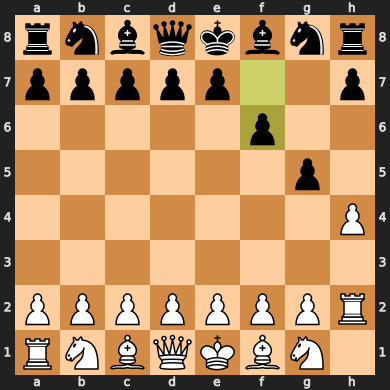

KeyboardInterrupt: Interrupted by user

In [7]:
# Random Vs. Random
random_agent = get_random_move
test_game(random_agent, random_agent)

In [ ]:
# Minimax Vs. Random
random_agent = get_random_move
minimax_agent = get_minimax_move
test_game(minimax_agent, random_agent)


In [ ]:
# Expectimax Vs. Random
random_agent = get_random_move
expectimax_agent = get_expectimax_move
test_game(expectimax_agent, random_agent)

In [ ]:
# Run several games at once without graphics
def grade_game(p1, p2):
    """
    Grades a single game at a time.
    (Note: differs from actual grading script, which has some ways to resolve draws.)

    Return legend:
    0: error during game
    1: p1 wins through checkmate
    2: p2 wins through checkmate
    3: draw
    """
    board = chess.Board()
    current_player = p1

    while not board.is_checkmate() and not board.is_stalemate() and not board.can_claim_draw():
        move = current_player(board, board.turn, MAX_DEPTH)
        try:
            board.push(move)
        except:            
            print(f"Error while grading game, move = {move}, current_player = {current_player}")
            print(board)
            return -1

        current_player = p1 if board.turn else p2
    
    outcome = board.outcome()
    if outcome is not None:
        if outcome.winner:
            return 1
        else:
            return 2
    
    return 3

In [ ]:
# Play many games in a row without visuals (faster)
random_agent = get_random_move
best_agent = get_best_move
num_games = 5

print(f"Playing {num_games} games...")
for i in range(1, num_games+1):
    result = grade_game(best_agent, random_agent)

    if result == 0:
        print(f"Game {i}: error pushing a move during gameplay")
        
    elif result == 1:
        print(f"Game {i}: p1 wins")
        
    elif result == 2:
        print(f"Game {i}: p1 loses")
    
    elif result == 3:
        print(f"Game {i}: draw")